# PyTorch Tutorial Workthrough

Here we work through a basic example in PyTorch. It is the example used in the [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html). 



## Load some libraries

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Tensors

The PyTorch library expects data inputs as tensors. For example, here we load some inflation data

In [2]:
# Load the data
data = pd.read_csv('datasets/CPALTT01USM657N.csv')
data.tail()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.rename(columns={'CPALTT01USM657N': 'inflation'})

,inflation
DATE,
1960-01-01,-0.340136
1960-01-02,0.341297
1960-01-03,0.000000
1960-01-04,0.340136
1960-01-05,0.000000
...,...
2023-01-03,0.331073
2023-01-04,0.505904
2023-01-05,0.251844


These can be transformed into a tensor like so, where we use the `values()` property of the dataframe. The resulting tensor has properties `shape` and `type` which give you the relevant shape and type information.

In [3]:
tensor = torch.tensor(data.values)
tensor.dtype
tensor.shape


torch.Size([763, 1])

Tensors are basically multi-dimensional matrices and you can do arithmatic with these. Find a [list of operations](https://pytorch.org/docs/stable/torch.html) to see what is available. 

## Example data

To follow the example in the PyTorch tutorial we need to load the Fashion-MNIST dataset. This dataset is already in the right format and we obtain a training and a testing portion for the dataset.

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:00<00:00, 31078387.66it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 1424190.17it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 15802399.81it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



These are image data, for instance the first image `training_data[1]` gives you information on the 28x28 pixels of an image.

In [8]:
training_data[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
           0.0000, 0.0000, 0.1608, 0.7373, 0.4039, 0.2118, 0.1882, 0.1686,
           0.3412, 0.6588, 0.5216, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.1922,
           0.5333, 0.8588, 0.8471, 0.8941, 0.9255, 1.0000, 1.0000, 1.0000,
           1.0000, 0.8510, 0.8431, 0.9961, 0.9059, 0.6275, 0.1765, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.6902, 0.8706,
           0.8784, 0.8314, 0.7961, 0.7765, 0.7686, 0.7843, 0.8431, 0.8000,
           0.7922, 0.7882, 0.7882, 0.7882, 0.8196, 0.8549, 0.8784, 0.6431,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7373, 0.8588, 0.7843,
           0.7765, 0.7922, 0.7765, 0.7804, 0.7804, 0.7882, 0.7686, 0.7765,
           0.7765, 0.7843, 0.7843, 0.7843, 

We can also visualise these images

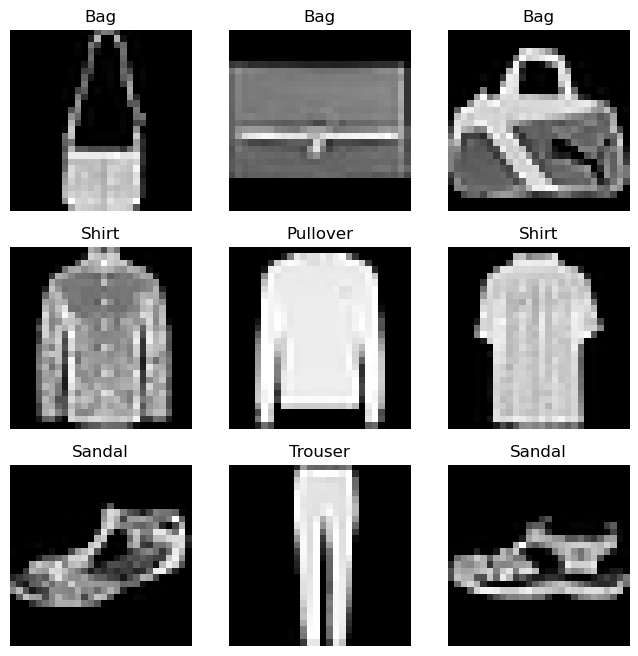

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We now have the data avaialable in `test_data` and `training_data`. For certain operations it will turn out to be useful to access the data via the DataLoader. This will enable access samples of data.

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

We indicated above that, if iterating through the data, we get random items. Each item has an image and a label.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


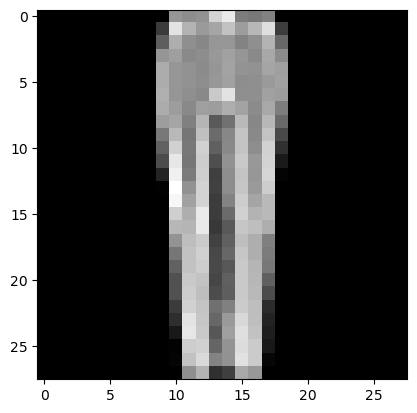

Label: 1


In [17]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [19]:
img, label = training_data[11]